In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy # CUDA interface for python
import cupy.linalg as LA
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 2.37 s


In [3]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.twbox[0].by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.twbox[0].bz,(2,1,0)).astype(np.float32)
#Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
#By = np.transpose(a.by,(2,1,0)).astype(np.float32)
#Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)
(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False
#plt.imshow(Bz[:,:,50].T) 

time: 1.3 s


In [4]:
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")
#print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)

compiling kernel
transfering B-field to GPU
time: 20.6 s


In [5]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=4
stride_step=1/interp_ratio

#A = cupy.array([350, 200,  5],dtype=cupy.float32)
#B = cupy.array([670, 200,  5],dtype=cupy.float32)
#C = cupy.array([350, 400,  5],dtype=cupy.float32)

A = cupy.array([410, 300.61,  0],dtype=cupy.float32)
B = cupy.array([880, 300.61,  0],dtype=cupy.float32)
C = cupy.array([410, 300.61,  150],dtype=cupy.float32)

x_range = [410,880]
y_range = [0,150]

CrossBC_dir = cupy.cross(B-A,C-A)/LA.norm(cupy.cross(B-A,C-A))
z0_dir = cupy.array([0,0,1],dtype=cupy.float32)

if LA.norm((A-B)*(A-C))<1e-9: # orthogonal check

    n = cupy.arange(LA.norm(A-B)*interp_ratio,dtype=cupy.float32) 
    m = cupy.arange(LA.norm(A-C)*interp_ratio,dtype=cupy.float32)
    
    n=n/cupy.max(n)
    m=m/cupy.max(m)

    N,M = cupy.meshgrid(n,m)
    
    x_arr = A[0]+(B-A)[0]*N+(C-A)[0]*M
    y_arr = A[1]+(B-A)[1]*N+(C-A)[1]*M
    z_arr = A[2]+(B-A)[2]*N+(C-A)[2]*M
   
    xy_shape = x_arr.shape
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = z_arr.flatten()
    
    line_len = cupy.zeros(x_inp.shape,cupy.float64)
    N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
    s_len    = cupy.array([1./8.],cupy.float32)
    tol_coef    = cupy.array([1.],cupy.float32)

    
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end
    )=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    
    # for GTX 1060
    # blck=(64,1,1)
    # grd = (20,1)

    # for GTX1080ti
    blck=(128,1,1)
    grd = (28,1)
    cupy.cuda.stream.get_current_stream().synchronize()
else:
    print('Init vec not orthogonal')

[1164  488  488]
time: 316 ms


In [6]:
x_arr.shape

(600, 1880)

time: 3.97 ms


In [7]:
# run the big calclation
TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
            x_inp,   y_inp,   z_inp, CrossBC_dir,
            x_start, y_start, z_start, flag_start,
            x_end,   y_end,   z_end,   flag_end,
            Bx_inp,  By_inp,  Bz_inp,  B_flag,
            Bx_start,By_start,Bz_start,
            Bx_end,  By_end,  Bz_end,  
            s_len,N,line_len, tol_coef*0.5))
cupy.cuda.stream.get_current_stream().synchronize()

time: 1.34 s


In [8]:
import FastQSL

(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
 x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
 Bx_in_arr,   By_in_arr,  Bz_in_arr,
 Bx_out_arr,  By_out_arr, Bz_out_arr,
 Bx_0_arr,    By_0_arr,   Bz_0_arr, B_flag_arr) = FastQSL.ResReshape(xy_shape,
                x_end,y_end,z_end,flag_end,
                x_start,y_start,z_start,flag_start,
                Bx_start,By_start,Bz_start,
                Bx_end,By_end,Bz_end,
                Bx_inp,By_inp,Bz_inp,B_flag)
Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bx_0_arr,    By_0_arr,   Bz_0_arr,    
         B_flag_arr, stride_step, CrossBC_dir)
cupy.cuda.stream.get_current_stream().synchronize()


stride_this  =  cupy.float32(1./interp_ratio)/8

(cut_inp_x,   cut_inp_y,   cut_inp_z,
    cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
    cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
    Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
    Bx_start_cut,By_start_cut,Bz_start_cut,
    Bx_end_cut,  By_end_cut,  Bz_end_cut,  
    N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
         x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bz_0_arr,    B_flag_arr, stride_this)


time: 101 ms


In [9]:
# run the big calclation
TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
            cut_inp_x,   cut_inp_y,   cut_inp_z, z0_dir, # use z0 as norm
            cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
            cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
            Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
            Bx_start_cut,By_start_cut,Bz_start_cut,
            Bx_end_cut,  By_end_cut,  Bz_end_cut,  
            s_len,N_cut,line_len_cut, tol_coef*.1))
cupy.cuda.stream.get_current_stream().synchronize()

time: 52 ms


In [10]:

(X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                 for _ in range(4)];

idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

# Z plane
X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
# Y plane
X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
# X plane
X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];

dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];

a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

bnr_cut = cupy.abs(Bz0_end)/(cupy.abs(Bz0_start))*((1/stride_this/2)**4)
Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
Qcut[cupy.where(Qcut<1.0)]=1.0

cupy.cuda.stream.get_current_stream().synchronize()

time: 18 ms


In [11]:
X2[0::4].shape

(25470,)

time: 2.97 ms


In [12]:
Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)

Q_all[1:-1,1:-1]=Q
Q_all[B_flag_arr==1]=Qcut
Q_final=Q_all[1:-1,1:-1]


time: 4 ms


In [13]:
Qcut

array([ 78.538925 ,   1.4256643,   1.9787138, ..., 347.73886  ,
       208.03732  , 181.6096   ], dtype=float32)

time: 4 ms


(0.0, 150.0)

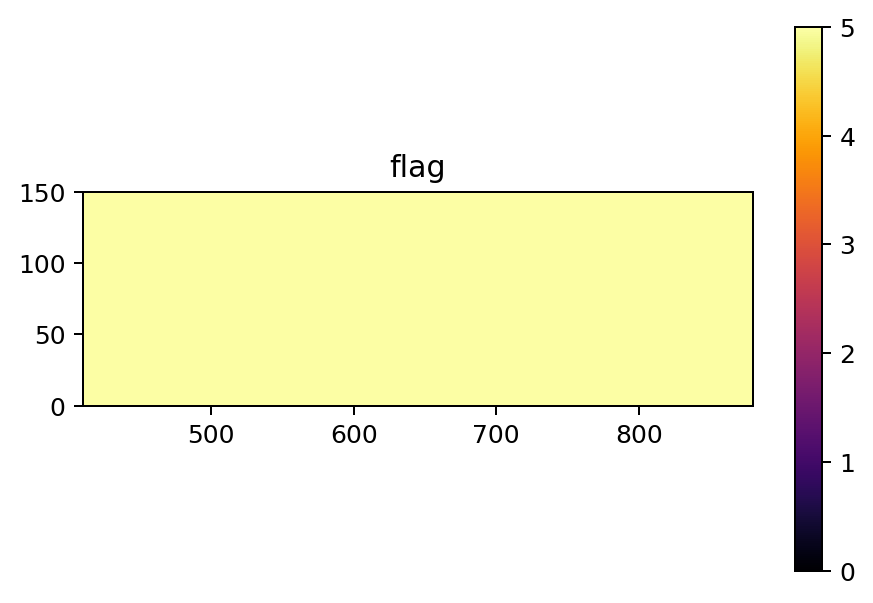

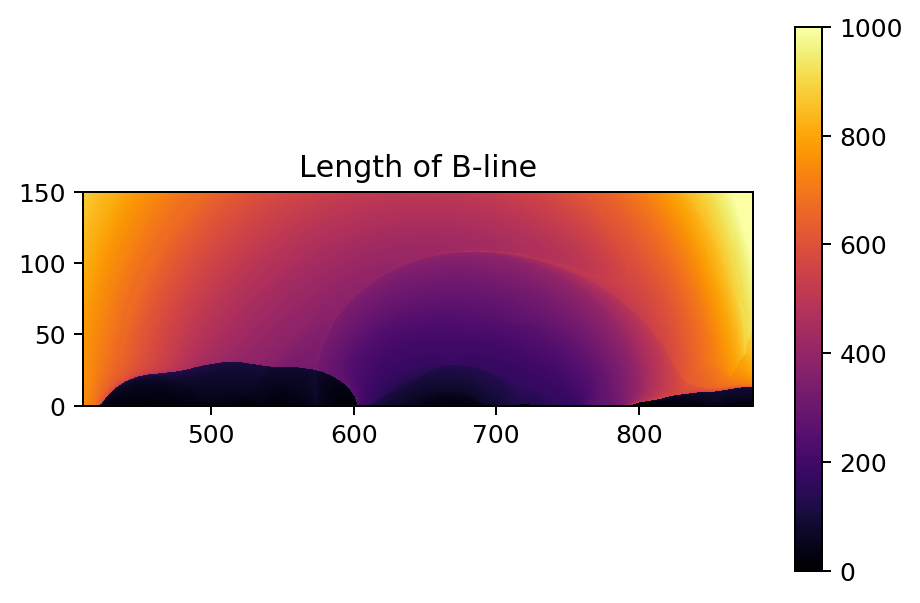

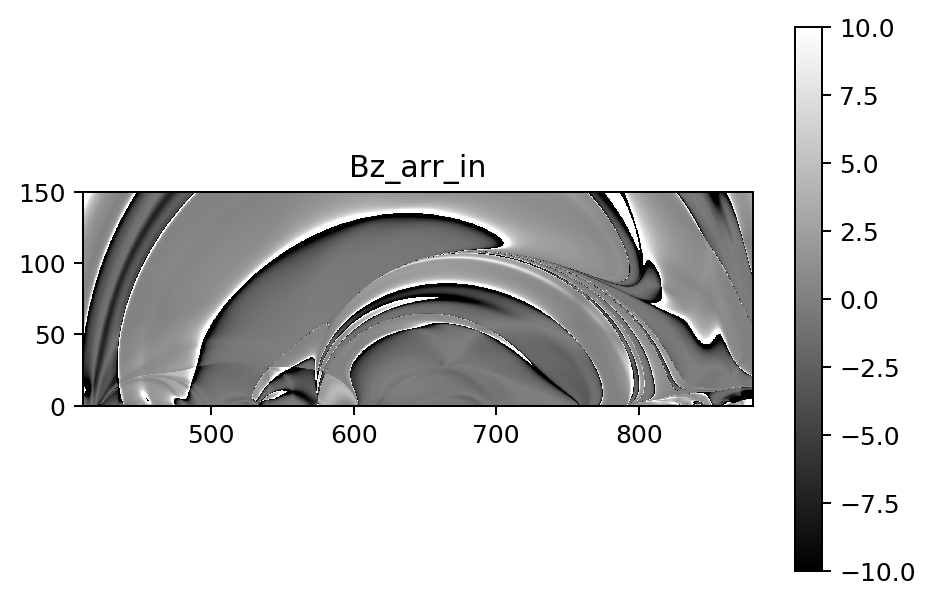

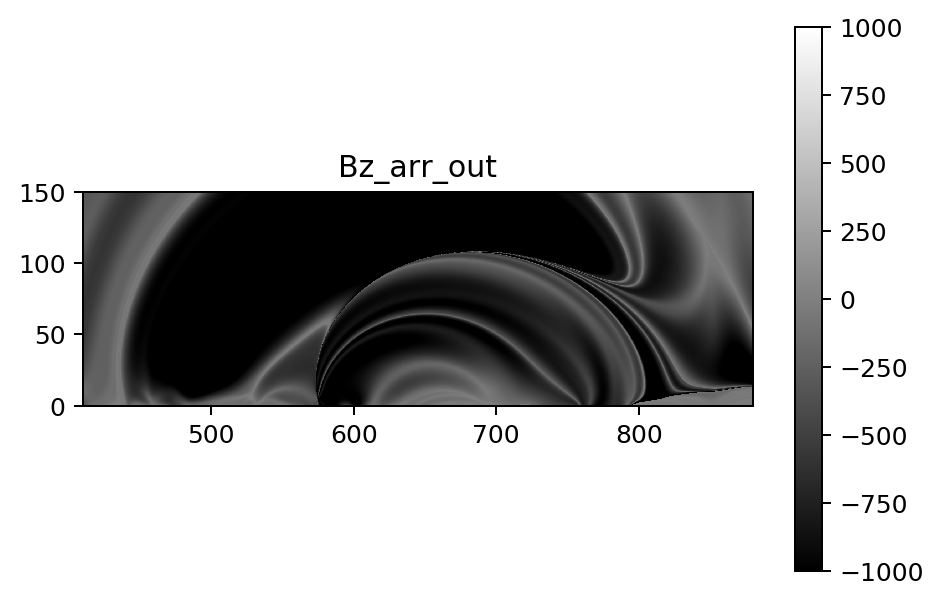

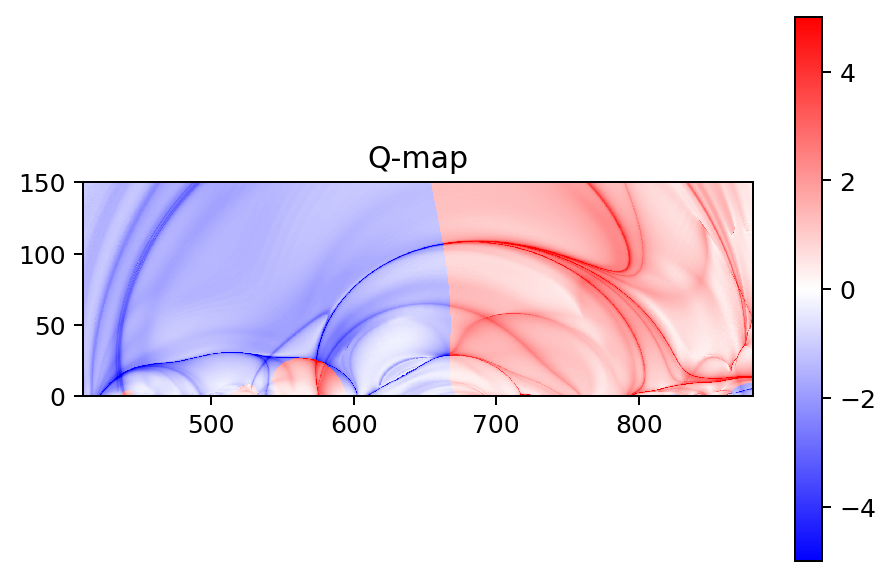

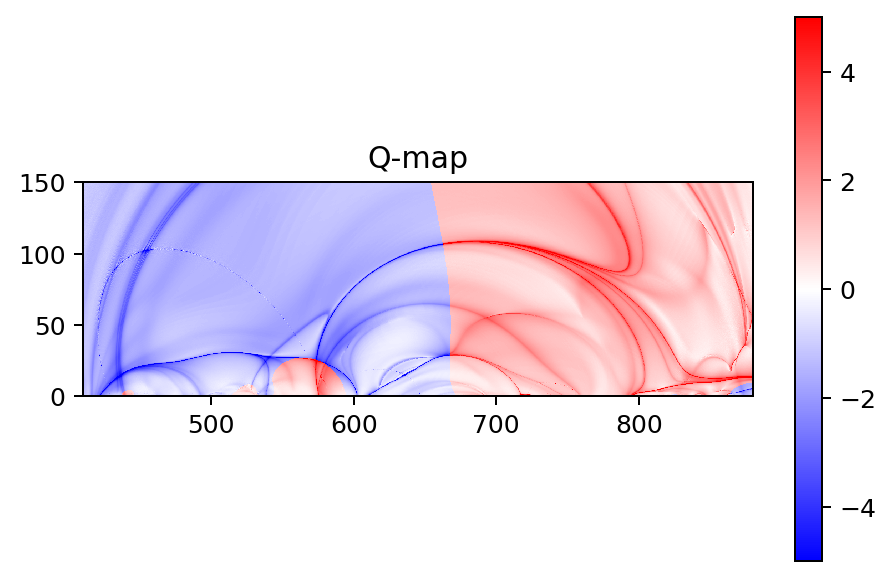

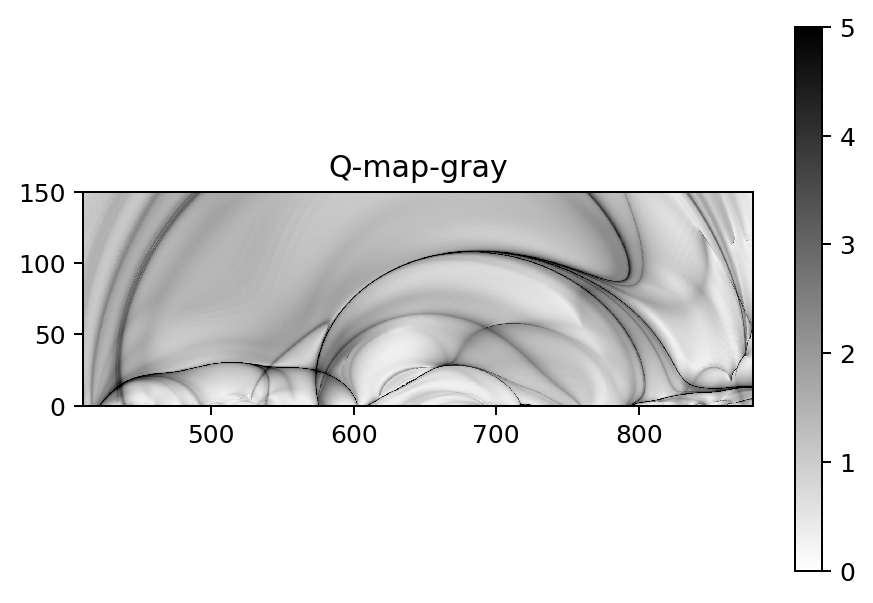

time: 2.67 s


In [16]:
plt.close()

xxlim=None
yylim=None

#xxlim=[400,720]
#yylim=[150,400]
#xxlim=[550,650]
#yylim=[200,270]
#xxlim= [350,670]
#yylim= [200,400]

dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flag_start_arr.get(),cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow((line_len.get().reshape(xy_shape)),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range],vmax=1000)
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_in_arr.get()/Bx_out_arr.get(),cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_out_arr.get(),cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q_final.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


fig=plt.figure(5,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_0_arr.get()[1:-1,1:-1])
                *(flag_start_arr.get()[1:-1,1:-1]<=6),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(6,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q_final.get())*(flag_start_arr.get()[1:-1,1:-1]<41),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


(0.0, 150.0)

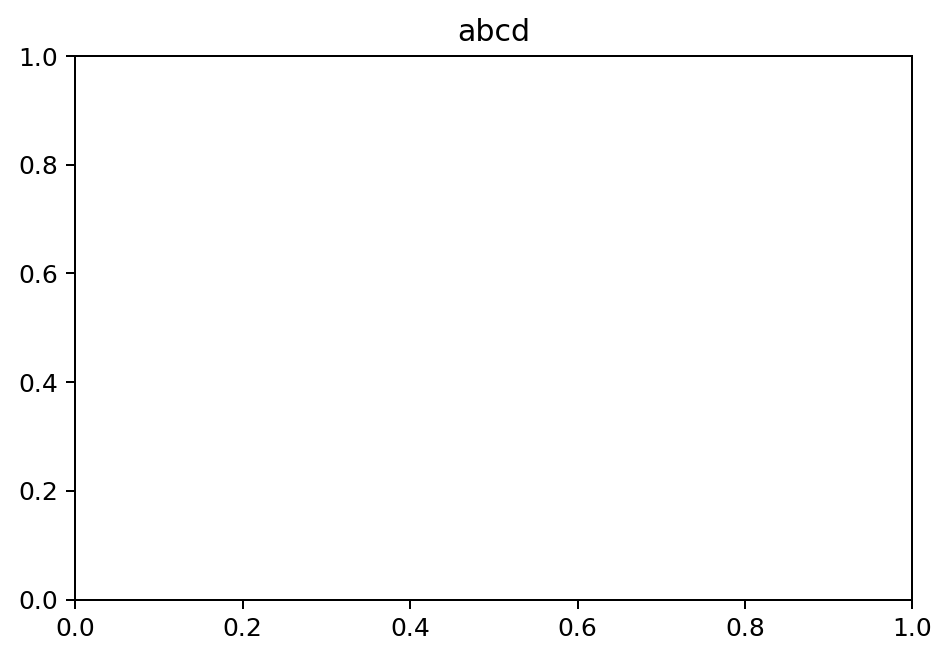

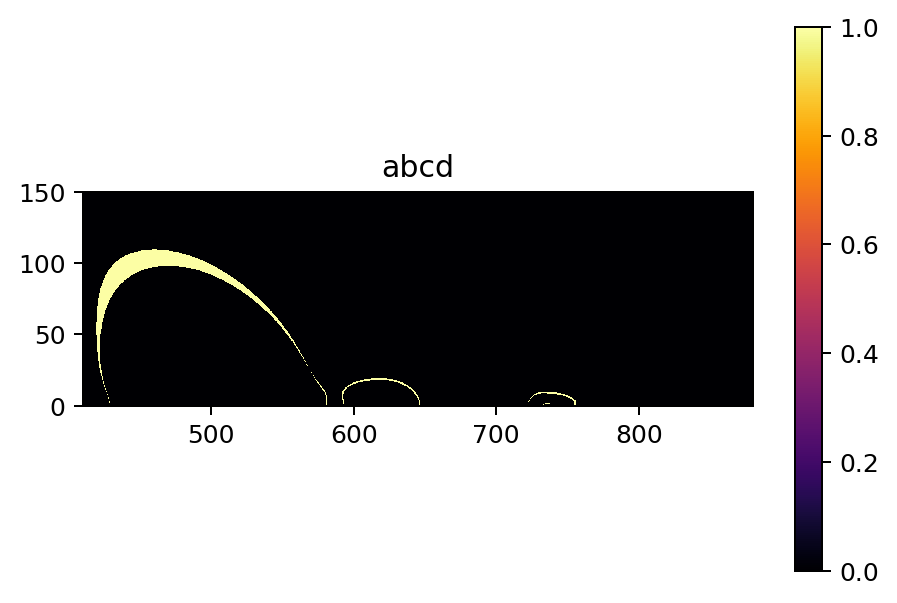

time: 517 ms


In [17]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
#img = ax.imshow(np.log((b.get())**2),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
#fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=180); ax = plt.gca() 
img = ax.imshow((B_flag_arr.get()),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)
